# Part 3: Recognition

In this part of the assignment, you will implement and train neural networks, including convolutional neural networks, for an image recognition task using PyTorch. Specifically, we will classify a number of grayscale images of pieces of clothing by predicting a label for the name of the clothing type.

**Learning objectives.** You will:
1. Define multilayer perceptrons and convolutional neural networks using PyTorch
2. Optimize neural networks using automatic differentation and minibatch stochastic gradient descent in PyTorch
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

While it is possible to complete this task using CPU compute, it may be slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

In [1]:
# Run but DO NOT MODIFY this code

# Import modules
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split

# Load Fashion MNIST datasets
train_data = datasets.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

# Create DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

The following code then visualizes some random examples of the training data.

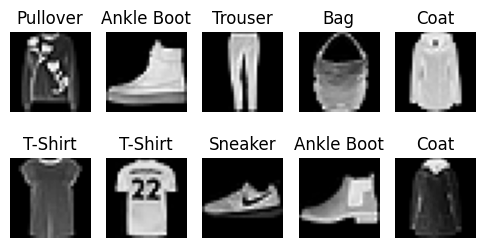

In [2]:
# Run but DO NOT MODIFY this code

# Visualize Random Examples
labels_map = {
    0: "T-Shirt", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

from matplotlib import pyplot as plt

figure = plt.figure(figsize=(6, 3))
cols, rows = 5, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Task 1

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a multilayer perceptron to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least at least two [linear layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) to connect between the input, hidden units, and an output units. You should use nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) at least for the hidden units. You may optionally include additional layers but are not required to do so.

Your model should not be excessively large beyond what is necessary to accomplish good performance (see the next task). After your code, briefly explain the architecture of your model including a discussion of the hidden layers and the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    
    def __init__(self, input_size=28*28, hidden_size1=100, hidden_size2=50, output_size=10):
        super(MLP, self).__init__()

        self.h1 = nn.Linear(input_size, hidden_size1)  # first hidden layer
        self.h2 = nn.Linear(hidden_size1, hidden_size2) # second hidden layer
        self.o = nn.Linear(hidden_size2, output_size) # output layer
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # reshape the tensor x so it can be forwardly propagated
        h1 = self.h1(x)  
        a1 = F.relu(h1)   
        h2 = self.h2(a1)  
        a2 = F.relu(h2)   
        logits = self.o(a2)   
        return logits

model = MLP()
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {param_count}")

Number of trainable parameters: 84060


I decided to use two hidden layers. By default, there are double as many nodes in the first hidden layer than the second one. I did this so that the model can capture a more complex data pattern in the first layer, and then simplify it a bit in the second layer so that the representation might be a little more generalizable. Overall, with an input size of 28x28, the first hidden layer having 100 nodes, the second one having 50 nodes, and an output size of 10, the total number of trainable parameters would be 84,060. 

## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)).

You should be able to achieve a validation accuracy of 83% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 1 if so) or the training hyperparameters to accomplish this. 

When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data. Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

def fit(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        train_acc = correct / total
        val_acc = predict(model, val_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

def predict(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

fit(model, train_loader, val_loader, epochs=10)
test_acc = predict(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/10 - Loss: 0.7562, Train Acc: 0.7311, Val Acc: 0.8261
Epoch 2/10 - Loss: 0.4568, Train Acc: 0.8365, Val Acc: 0.8418
Epoch 3/10 - Loss: 0.4020, Train Acc: 0.8543, Val Acc: 0.8588
Epoch 4/10 - Loss: 0.3729, Train Acc: 0.8642, Val Acc: 0.8644
Epoch 5/10 - Loss: 0.3476, Train Acc: 0.8736, Val Acc: 0.8527
Epoch 6/10 - Loss: 0.3322, Train Acc: 0.8789, Val Acc: 0.8583
Epoch 7/10 - Loss: 0.3206, Train Acc: 0.8814, Val Acc: 0.8763
Epoch 8/10 - Loss: 0.3085, Train Acc: 0.8861, Val Acc: 0.8680
Epoch 9/10 - Loss: 0.2983, Train Acc: 0.8909, Val Acc: 0.8745
Epoch 10/10 - Loss: 0.2898, Train Acc: 0.8927, Val Acc: 0.8796
Test Accuracy: 0.8679


Learning rate: 0.01, Momentum: 0.9, Weight decay: 1e-4, Batch size: 64, Epochs: 10

## Task 3

Using [PyTorch](https://pytorch.org/docs/stable/torch.html), define a convolutional neural network to classify the images. At a minimum you should complete the todos for the two methods defined below (but feel free to add additional helper methods as needed). Your model should contain at least one [convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), nonlinear activations such as the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) or [sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), at least one [pooling layer](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), and at least one fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), though you may choose to use a deeper model with additional layers to achieve good performance.

Your model should not be excessively large beyond what is necessary to accomplish good performance. After your code, briefly explain the architecture of your model including a discussion of all of the hidden layers including choice of any parameters such as kernels or strides, as well as the total number of model parameters. Justify your answer either by calculating the number of parameters by hand or by explicitly inspecting the `.parameters()` of your model in code.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

class ConvNN(nn.Module):
    
    def __init__(self):
        super(ConvNN, self).__init__()
    
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 60)  
        self.fc2 = nn.Linear(60, 10)  
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ConvNN()
param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {param_count}")

Number of trainable parameters: 99550


I have the first convolutional layer with 16 filters, a 3x3 kernel, stride 1, and padding of 1. Between that layer and the next, as well as I use ReLU and 2x2 Max-pooling. In the second convolutional layer I have 32 filters, a 3x3 kernel, a stride of 1, and padding of 1. Then I have a hidden layer with 60 neurons and an output layer with 10 neurons. In total, there are 105,866 trainable parameters.

## Task 4

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fit the parameters of your model on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). 

Instead of using printouts to monitor training, use the more professional PyTorch `Tensorboard` utility as [described in the tutorial documentation here](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html). Log the (a) training loss, (b) validation loss, and (c) validation accuracy over the course of training using `Tensorboard` (you likely only want to compute validation accuracy once per epoch, but you can log the loss more often if you wish). For your final training run, report the visualizations created by Tensorboard. You can export the visualizations from Tensorboard by selecting "SCALARs" (upper left), "Show data download links", and "Download" under each image, or you can just take screenshots. You can [add images using markdown as shown in the documentation](https://www.markdownguide.org/cheat-sheet/#basic-syntax).

You should be able to achieve a validation accuracy of 88% or better without using more than 100,000 model parameters, though you may need to experiment with the architecture of the network (make sure to edit Task 3 if so) or the training hyperparameters to accomplish this. In particular, you should demonstrate improved performance (while still using fewer than 100,000 parameters) compared to your previous multilayer perceptron. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [21]:
#!pip install torch torchvision
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
import tensorflow as tf

learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
epochs = 20

model = ConvNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
writer = SummaryWriter("logs/cnn_experiment")

def fit():
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        writer.add_scalar("Loss/Train", avg_train_loss, epoch) 
        writer.flush()  
        
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / len(val_set)
        
        writer.add_scalar("Loss/Validation", avg_val_loss, epoch)  
        writer.add_scalar("Accuracy/Validation", val_accuracy, epoch)  
        writer.flush()  
        
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")
        
    print("Training complete.")

def predict():
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    
    test_accuracy = correct / len(test_data)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    writer.add_scalar("Accuracy/Test", test_accuracy)  # Log test accuracy

%load_ext tensorboard
fit()
!ls logs/cnn_experiment
%tensorboard --logdir logs/cnn_experiment
predict()

writer.flush()  
writer.close()

notebook.list() 
#notebook.display(port=6006, height=1000) 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1: Train Loss = 0.7389, Val Loss = 0.4391, Val Accuracy = 0.8440
Epoch 2: Train Loss = 0.3947, Val Loss = 0.3748, Val Accuracy = 0.8670
Epoch 3: Train Loss = 0.3319, Val Loss = 0.3237, Val Accuracy = 0.8791
Epoch 4: Train Loss = 0.2997, Val Loss = 0.2884, Val Accuracy = 0.8944
Epoch 5: Train Loss = 0.2760, Val Loss = 0.2791, Val Accuracy = 0.8972
Epoch 6: Train Loss = 0.2598, Val Loss = 0.2955, Val Accuracy = 0.8921
Epoch 7: Train Loss = 0.2446, Val Loss = 0.2534, Val Accuracy = 0.9059
Epoch 8: Train Loss = 0.2303, Val Loss = 0.2598, Val Accuracy = 0.9048
Epoch 9: Train Loss = 0.2193, Val Loss = 0.2493, Val Accuracy = 0.9080
Epoch 10: Train Loss = 0.2092, Val Loss = 0.2422, Val Accuracy = 0.9124
Epoch 11: Train Loss = 0.1982, Val Loss = 0.2437, Val Accuracy = 0.9137
Epoch 12: Train Loss = 0.1905, Val Loss = 0.2340, Val Accuracy = 0.9158
Epoch 13: Train Loss = 0.1818, Val Loss = 0.2393, Val A

Test Accuracy: 0.9077
Known TensorBoard instances:
  - port 6006: logdir logs/cnn_experiment (started 0:00:02 ago; pid 2341657)


In [20]:
#troubleshooting
import torch
import tensorflow as tf

#!pip install tensorflow==2.12.0
!nvidia-smi

# Enable logging to see where operations are placed (CPU or GPU)
tf.debugging.set_log_device_placement(True)

# Test operation to see where it's being run
a = tf.random.normal([10000, 10000])
b = tf.random.normal([10000, 10000])
c = tf.matmul(a, b)
print("TensorFlow operation complete.")

# Try listing devices explicitly (this should also give an error if TensorFlow cannot access the GPU)
physical_devices = tf.config.list_physical_devices('GPU')
print(f"Detected GPUs: {physical_devices}")

# Try to explicitly set memory growth
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

# Run a simple test operation if a GPU is detected
if physical_devices:
    with tf.device('/GPU:0'):
        a = tf.random.normal([10000, 10000])
        b = tf.random.normal([10000, 10000])
        c = tf.matmul(a, b)
        print("Test run on GPU complete.")
else:
    print("No GPU available for TensorFlow.")


print("TensorFlow version:", tf.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Current CUDA device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Fri Mar  7 12:34:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-12GB           Off |   00000000:82:00.0 Off |                    0 |
| N/A   26C    P0             28W /  250W |     399MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

I used a learning rate of 0.01, momentum of 0.9,
weight decay of 1e-4 and 20 epochs. Please note that I was unable to use tensorboard - or at least I can't see the output. It seems that my results are being written into a file called "logs" but I am unable to open the file as it is not UTF-8 encoded. I did a lot of troubleshooting (see above) and it seems like my problem is that TensorFlow is unable to detect the GPU I am using. I tried multiple things to remedy this, to no avail. I have been suck on this for more than 4 hours, so I have to move on. 